# Restaurant Rating Prediction (1–5) — EDA + 3 Skenario (Struktur Dipisah Per Model)

Notebook ini disusun ulang agar **alur skenario jelas** dan **blok model berada di skenario masing-masing**.

## Ringkas Struktur

1. Setup, Load Data, Preprocessing (lemmatization), EDA, Split.
2. **Skenario 1 — Baseline sederhana**: hanya **Linear SVM** dan **Naive Bayes**.
3. **Skenario 2 — Perbandingan 5 model (no aug)**:
   - Linear SVM
   - Naive Bayes
   - LSTM
   - BERT
   - RoBERTa
     > Masing-masing model dipisah bloknya.
4. **Skenario 3 — Dampak augmentasi**: strategi augmentasi diterapkan pada train, lalu
   **kelima model yang sama** dilatih ulang (blok per model) untuk setiap strategi.

## Catatan CPU

Jika tidak ada GPU, BERT/RoBERTa tetap aktif dengan konfigurasi lebih ringan.


## 0. Setup & Library


In [1]:
%pip -q install pandas numpy scikit-learn matplotlib nltk tqdm
%pip -q install torch transformers datasets evaluate accelerate
%pip -q install nlpaug

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [23]:

# !pip -q install pandas numpy scikit-learn matplotlib nltk tqdm
# !pip -q install torch transformers datasets evaluate accelerate
# !pip -q install nlpaug

import os, re, glob, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

HAS_GPU = torch.cuda.is_available()
DEVICE = "cuda" if HAS_GPU else "cpu"
print("Device:", DEVICE)


Device: cpu


## 1. Load Dataset


In [24]:

DATA_PATH = "dataset/reviews.csv"  # <-- ganti sesuai file Anda

if not os.path.exists(DATA_PATH):
    candidates = glob.glob("**/*.csv", recursive=True)
    preferred = [c for c in candidates if re.search(r"(review|google|maps|restaurant)", c, re.I)]
    if preferred:
        DATA_PATH = preferred[0]
    elif candidates:
        DATA_PATH = candidates[0]

print("Using DATA_PATH:", DATA_PATH)

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Using DATA_PATH: dataset/reviews.csv
Shape: (1100, 6)


,business_name,author_name,text,photo,rating,rating_category
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu


## 2. Cleaning & Text Preprocessing (Lemmatization)


Preprocessing:

- normalisasi spasi
- lowercasing
- pembersihan karakter non-alfabet sederhana
- tokenisasi
- **lemmatization** WordNet dengan POS tagger.

Blok download NLTK dibuat **robust** untuk versi lama/baru.


In [25]:

import nltk

resources = [
    ("tokenizers/punkt", "punkt"),
    ("taggers/averaged_perceptron_tagger", "averaged_perceptron_tagger"),
    ("taggers/averaged_perceptron_tagger_eng", "averaged_perceptron_tagger_eng"),
    ("corpora/wordnet", "wordnet"),
    ("corpora/omw-1.4", "omw-1.4"),
]

for path, name in resources:
    try:
        nltk.data.find(path)
    except LookupError:
        nltk.download(name)

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

def penn_to_wn(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    if tag.startswith("V"):
        return wordnet.VERB
    if tag.startswith("N"):
        return wordnet.NOUN
    if tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN

def basic_normalize(text: str) -> str:
    text = str(text).strip()
    text = re.sub(r"\s+", " ", text)
    return text

def clean_for_lemma(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def lemmatize_text(text: str) -> str:
    text = clean_for_lemma(basic_normalize(text))
    if not text:
        return ""
    toks = word_tokenize(text)
    pos_tags = nltk.pos_tag(toks)
    lemmas = [lemmatizer.lemmatize(w, penn_to_wn(t)) for w, t in pos_tags]
    return " ".join(lemmas)

assert "text" in df.columns, "Kolom 'text' tidak ditemukan."
assert "rating" in df.columns, "Kolom 'rating' tidak ditemukan."

df = df.dropna(subset=["text", "rating"]).copy()
df["rating"] = df["rating"].astype(int)
df = df[df["rating"].between(1, 5)]

df["text_basic"] = df["text"].apply(basic_normalize)
df["text_lemma"] = df["text"].apply(lemmatize_text)
df["text_clean"] = df["text_lemma"]

print("After cleaning:", df.shape)
df.head()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


After cleaning: (1100, 9)


,business_name,author_name,text,photo,rating,rating_category,text_basic,text_lemma,text_clean
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste,We went to Marmaris with my wife for a holiday...,we go to marmaris with my wife for a holiday w...,we go to marmaris with my wife for a holiday w...
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu,During my holiday in Marmaris we ate here to f...,during my holiday in marmaris we eat here to f...,during my holiday in marmaris we eat here to f...
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere,Prices are very affordable. The menu in the ph...,price be very affordable the menu in the photo...,price be very affordable the menu in the photo...
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere,Turkey's cheapest artisan restaurant and its f...,turkey s cheap artisan restaurant and it food ...,turkey s cheap artisan restaurant and it food ...
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu,I don't know what you will look for in terms o...,i don t know what you will look for in term of...,i don t know what you will look for in term of...


## 3. Exploratory Data Analysis (EDA)


In [26]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_name    1100 non-null   object
 1   author_name      1100 non-null   object
 2   text             1100 non-null   object
 3   photo            1100 non-null   object
 4   rating           1100 non-null   int64 
 5   rating_category  1100 non-null   object
 6   text_basic       1100 non-null   object
 7   text_lemma       1100 non-null   object
 8   text_clean       1100 non-null   object
dtypes: int64(1), object(8)
memory usage: 77.5+ KB


In [27]:

rating_counts = df["rating"].value_counts().sort_index()
rating_counts


rating
1     80
2     72
3    172
4    316
5    460
Name: count, dtype: int64

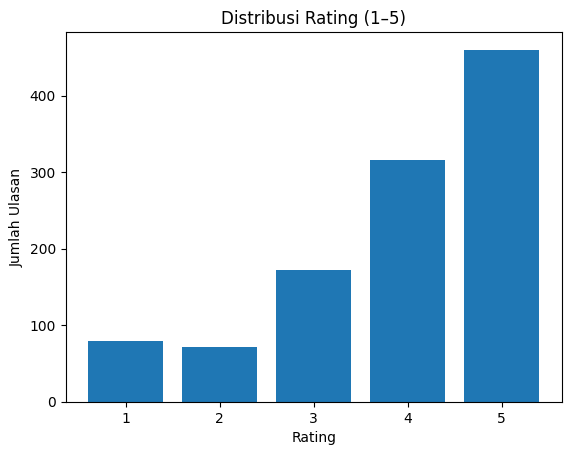

In [28]:

plt.figure()
plt.bar(rating_counts.index.astype(str), rating_counts.values)
plt.title("Distribusi Rating (1–5)")
plt.xlabel("Rating")
plt.ylabel("Jumlah Ulasan")
plt.show()


In [29]:

df["char_len"] = df["text_basic"].str.len()
df["word_len"] = df["text_basic"].str.split().apply(len)

df[["char_len", "word_len"]].describe()


,char_len,word_len
count,1100.000000,1100.000000
mean,110.827273,20.051818
std,69.144698,12.977619
min,5.000000,1.000000
25%,62.000000,11.000000
50%,104.000000,19.000000
75%,147.000000,27.000000
max,914.000000,179.000000


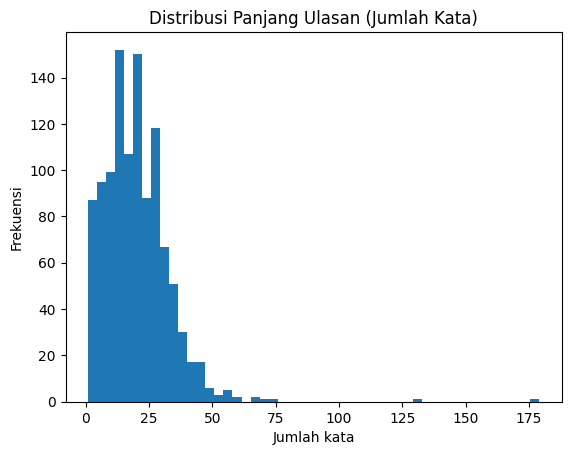

In [30]:

plt.figure()
plt.hist(df["word_len"], bins=50)
plt.title("Distribusi Panjang Ulasan (Jumlah Kata)")
plt.xlabel("Jumlah kata")
plt.ylabel("Frekuensi")
plt.show()


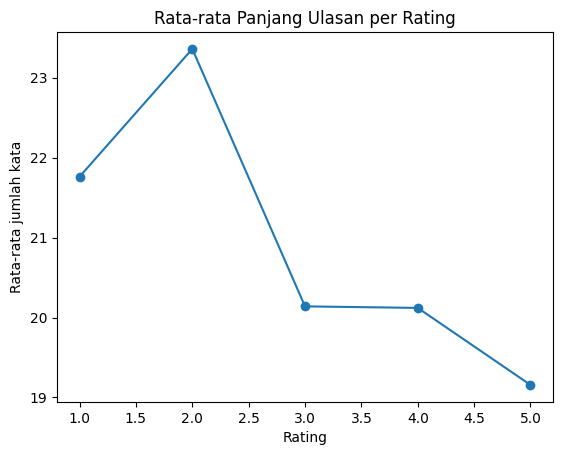

rating
1    21.762500
2    23.361111
3    20.139535
4    20.120253
5    19.156522
Name: word_len, dtype: float64

In [31]:

avg_len = df.groupby("rating")["word_len"].mean()

plt.figure()
plt.plot(avg_len.index, avg_len.values, marker="o")
plt.title("Rata-rata Panjang Ulasan per Rating")
plt.xlabel("Rating")
plt.ylabel("Rata-rata jumlah kata")
plt.show()

avg_len


## 4. Train/Test Split (Konsisten)


In [32]:

X = df["text_clean"].values
y = df["rating"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print("Train:", len(X_train), "Test:", len(X_test))
print("Distribusi Train:", Counter(y_train))
print("Distribusi Test :", Counter(y_test))


Train: 880 Test: 220
Distribusi Train: Counter({np.int64(5): 368, np.int64(4): 253, np.int64(3): 137, np.int64(1): 64, np.int64(2): 58})
Distribusi Test : Counter({np.int64(5): 92, np.int64(4): 63, np.int64(3): 35, np.int64(1): 16, np.int64(2): 14})


## 5. Utilitas Evaluasi


In [33]:

def eval_report(y_true, y_pred, title="Model"):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    f1w = f1_score(y_true, y_pred, average="weighted")

    print(f"=== {title} ===")
    print("Accuracy :", round(acc, 4))
    print("F1-macro :", round(f1m, 4))
    print("F1-weight:", round(f1w, 4))
    print()
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))
    print()
    return {"model": title, "accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w}

def plot_confusion(y_true, y_pred, labels=range(1, 6), title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=list(labels))
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)

    thresh = cm.max() / 2 if cm.size else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()


## 6. Helper Model Klasik (TF–IDF)


In [34]:

def fit_tfidf(train_texts, test_texts):
    vec = TfidfVectorizer(lowercase=True, max_features=50000, ngram_range=(1, 2))
    Xtr = vec.fit_transform(train_texts)
    Xte = vec.transform(test_texts)
    return vec, Xtr, Xte

def train_eval_svm(train_texts, train_labels, test_texts, test_labels, suffix=""):
    vec, Xtr, Xte = fit_tfidf(train_texts, test_texts)
    svm = LinearSVC()
    svm.fit(Xtr, train_labels)
    pred = svm.predict(Xte)
    res = eval_report(test_labels, pred, f"Linear SVM{suffix}")
    return res, vec, svm, pred

def train_eval_nb(train_texts, train_labels, test_texts, test_labels, suffix=""):
    vec, Xtr, Xte = fit_tfidf(train_texts, test_texts)
    nb = MultinomialNB()
    nb.fit(Xtr, train_labels)
    pred = nb.predict(Xte)
    res = eval_report(test_labels, pred, f"Naive Bayes{suffix}")
    return res, vec, nb, pred


## 7. Helper LSTM (PyTorch)


In [35]:

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight

def build_vocab(texts, max_vocab=30000, min_freq=2):
    from collections import Counter as CCounter
    counter = CCounter()
    for t in texts:
        counter.update(str(t).split())
    vocab = {"<pad>": 0, "<unk>": 1}
    for w, c in counter.most_common():
        if c < min_freq:
            continue
        if len(vocab) >= max_vocab:
            break
        vocab[w] = len(vocab)
    return vocab

def encode(text, vocab, max_len=200):
    tokens = str(text).split()
    ids = [vocab.get(t, vocab["<unk>"]) for t in tokens[:max_len]]
    if len(ids) < max_len:
        ids += [vocab["<pad>"]] * (max_len - len(ids))
    return ids

class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=200):
        self.texts = list(texts)
        self.labels = list(labels)
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x = torch.tensor(encode(self.texts[idx], self.vocab, self.max_len), dtype=torch.long)
        y = torch.tensor(int(self.labels[idx]) - 1, dtype=torch.long)  # 1-5 -> 0-4
        return x, y

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=128, num_classes=5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        emb = self.embedding(x)
        out, _ = self.lstm(emb)
        last = out[:, -1, :]
        last = self.dropout(last)
        return self.fc(last)

def train_eval_lstm(
    train_texts, train_labels, test_texts, test_labels,
    epochs=3, max_len=200, batch_size=64, suffix="",
    use_class_weights=False
):
    vocab = build_vocab(train_texts)
    train_ds = TextDataset(train_texts, train_labels, vocab, max_len)
    test_ds  = TextDataset(test_texts, test_labels, vocab, max_len)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    model = LSTMClassifier(len(vocab)).to(DEVICE)

    if use_class_weights:
        classes = np.array([1,2,3,4,5])
        cw = compute_class_weight(class_weight="balanced", classes=classes, y=np.array(train_labels))
        class_weights = torch.tensor(cw, dtype=torch.float).to(DEVICE)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    def train_one_epoch():
        model.train()
        total = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            total += float(loss.item())
        return total / max(1, len(train_loader))

    def predict():
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(DEVICE)
                logits = model(xb)
                p = torch.argmax(logits, dim=1).cpu().numpy()
                preds.extend(list(p))
                trues.extend(list(yb.numpy()))
        preds = np.array(preds) + 1
        trues = np.array(trues) + 1
        return trues, preds

    for ep in range(epochs):
        loss = train_one_epoch()
        print(f"[LSTM{suffix}] Epoch {ep+1}/{epochs} | loss={loss:.4f}")

    yt, yp = predict()
    return eval_report(yt, yp, f"LSTM{suffix}")


## 8. Helper Transformer (BERT & RoBERTa) — Versi Robust API


In [36]:

from datasets import Dataset
import evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

DEFAULT_MAX_LEN = 256 if HAS_GPU else 128
DEFAULT_BATCH = 8 if HAS_GPU else 2
DEFAULT_EPOCHS = 1

USE_SMALL_TRAIN_IF_CPU = True
SMALL_TRAIN_N = 2000

def make_hf_dataset(texts, labels):
    return Dataset.from_dict({"text": list(texts), "label": [int(l) - 1 for l in labels]})

def make_tokenize_fn(tokenizer, max_length):
    def _tok(batch):
        return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=max_length)
    return _tok

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1m = f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    f1w = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return {"accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w}

def maybe_shrink_train(train_texts, train_labels):
    if (not HAS_GPU) and USE_SMALL_TRAIN_IF_CPU and len(train_texts) > SMALL_TRAIN_N:
        return train_texts[:SMALL_TRAIN_N], train_labels[:SMALL_TRAIN_N]
    return train_texts, train_labels

def build_training_args(out_dir, epochs, batch_size):
    common = dict(
        output_dir=out_dir,
        save_strategy="no",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_steps=50,
        report_to="none",
        seed=SEED,
        fp16=HAS_GPU,
        dataloader_num_workers=0,
    )
    try:
        return TrainingArguments(**common, evaluation_strategy="epoch")
    except TypeError:
        return TrainingArguments(**common, eval_strategy="epoch")

def train_eval_transformer(
    model_name,
    train_texts, train_labels,
    test_texts, test_labels,
    epochs=DEFAULT_EPOCHS, batch_size=DEFAULT_BATCH,
    max_length=DEFAULT_MAX_LEN, out_dir="./tmp_tr", suffix=""
):
    train_texts2, train_labels2 = maybe_shrink_train(train_texts, train_labels)

    train_hf = make_hf_dataset(train_texts2, train_labels2)
    test_hf  = make_hf_dataset(test_texts, test_labels)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

    tok_fn = make_tokenize_fn(tokenizer, max_length=max_length)
    train_tok = train_hf.map(tok_fn, batched=True)
    test_tok  = test_hf.map(tok_fn, batched=True)

    # remove raw text column for safety
    train_tok = train_tok.remove_columns(["text"])
    test_tok  = test_tok.remove_columns(["text"])

    args = build_training_args(out_dir, epochs, batch_size)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=test_tok,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    res = trainer.evaluate()
    print(f"=== {model_name}{suffix} ===")
    print(res)
    print()
    return {"model": model_name + suffix, **res}


## 9. Skenario 1 — Baseline Sederhana (Fokus Class Imbalance)


### 9.1 Linear SVM (S1)


In [37]:

results_s1 = []

svm_s1_res, svm_s1_vec, svm_s1_model, svm_s1_pred = train_eval_svm(
    X_train, y_train, X_test, y_test, suffix=" (S1 baseline)"
)
results_s1.append(svm_s1_res)


=== Linear SVM (S1 baseline) ===
Accuracy : 0.5
F1-macro : 0.3758
F1-weight: 0.4734

              precision    recall  f1-score   support

           1     0.5556    0.3125    0.4000        16
           2     0.3333    0.0714    0.1176        14
           3     0.3571    0.2857    0.3175        35
           4     0.3966    0.3651    0.3802        63
           5     0.5820    0.7717    0.6636        92

    accuracy                         0.5000       220
   macro avg     0.4449    0.3613    0.3758       220
weighted avg     0.4754    0.5000    0.4734       220




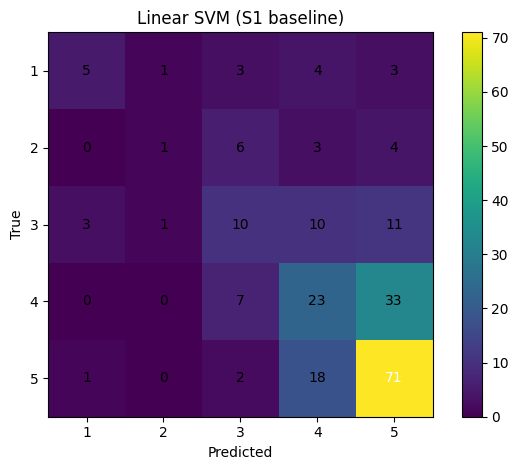

In [38]:

plot_confusion(y_test, svm_s1_pred, title="Linear SVM (S1 baseline)")


### 9.2 Naive Bayes (S1)


In [39]:

nb_s1_res, nb_s1_vec, nb_s1_model, nb_s1_pred = train_eval_nb(
    X_train, y_train, X_test, y_test, suffix=" (S1 baseline)"
)
results_s1.append(nb_s1_res)

s1_table = pd.DataFrame(results_s1)
s1_table


=== Naive Bayes (S1 baseline) ===
Accuracy : 0.4364
F1-macro : 0.1479
F1-weight: 0.2912

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        16
           2     0.0000    0.0000    0.0000        14
           3     0.0000    0.0000    0.0000        35
           4     0.5000    0.0794    0.1370        63
           5     0.4333    0.9891    0.6026        92

    accuracy                         0.4364       220
   macro avg     0.1867    0.2137    0.1479       220
weighted avg     0.3244    0.4364    0.2912       220




,model,accuracy,f1_macro,f1_weighted
0,Linear SVM (S1 baseline),0.500000,0.375765,0.473433
1,Naive Bayes (S1 baseline),0.436364,0.147927,0.291245


## 10. Skenario 2 — Perbandingan 5 Model (No Aug)


### 10.1 Linear SVM (S2)


In [40]:

results_s2 = []

svm_s2_res, svm_s2_vec, svm_s2_model, svm_s2_pred = train_eval_svm(
    X_train, y_train, X_test, y_test, suffix=" (S2 no aug)"
)
results_s2.append(svm_s2_res)


=== Linear SVM (S2 no aug) ===
Accuracy : 0.5
F1-macro : 0.3758
F1-weight: 0.4734

              precision    recall  f1-score   support

           1     0.5556    0.3125    0.4000        16
           2     0.3333    0.0714    0.1176        14
           3     0.3571    0.2857    0.3175        35
           4     0.3966    0.3651    0.3802        63
           5     0.5820    0.7717    0.6636        92

    accuracy                         0.5000       220
   macro avg     0.4449    0.3613    0.3758       220
weighted avg     0.4754    0.5000    0.4734       220




### 10.2 Naive Bayes (S2)


In [41]:

nb_s2_res, nb_s2_vec, nb_s2_model, nb_s2_pred = train_eval_nb(
    X_train, y_train, X_test, y_test, suffix=" (S2 no aug)"
)
results_s2.append(nb_s2_res)


=== Naive Bayes (S2 no aug) ===
Accuracy : 0.4364
F1-macro : 0.1479
F1-weight: 0.2912

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        16
           2     0.0000    0.0000    0.0000        14
           3     0.0000    0.0000    0.0000        35
           4     0.5000    0.0794    0.1370        63
           5     0.4333    0.9891    0.6026        92

    accuracy                         0.4364       220
   macro avg     0.1867    0.2137    0.1479       220
weighted avg     0.3244    0.4364    0.2912       220




### 10.3 LSTM (S2)


In [42]:

try:
    # S2 default: tanpa class weighting (pure no-aug baseline)
    lstm_s2_res = train_eval_lstm(
        X_train, y_train, X_test, y_test,
        epochs=3, suffix=" (S2 no aug)",
        use_class_weights=False
    )
    results_s2.append(lstm_s2_res)
except Exception as e:
    print("LSTM S2 error:", e)


[LSTM (S2 no aug)] Epoch 1/3 | loss=1.5551
[LSTM (S2 no aug)] Epoch 2/3 | loss=1.4000
[LSTM (S2 no aug)] Epoch 3/3 | loss=1.3936
=== LSTM (S2 no aug) ===
Accuracy : 0.4182
F1-macro : 0.1179
F1-weight: 0.2466

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        16
           2     0.0000    0.0000    0.0000        14
           3     0.0000    0.0000    0.0000        35
           4     0.0000    0.0000    0.0000        63
           5     0.4182    1.0000    0.5897        92

    accuracy                         0.4182       220
   macro avg     0.0836    0.2000    0.1179       220
weighted avg     0.1749    0.4182    0.2466       220




### 10.4 BERT (S2)


In [43]:

try:
    bert_s2_res = train_eval_transformer(
        "bert-base-uncased",
        X_train, y_train, X_test, y_test,
        epochs=DEFAULT_EPOCHS,
        batch_size=DEFAULT_BATCH,
        max_length=DEFAULT_MAX_LEN,
        out_dir="./tmp_bert_s2",
        suffix=" (S2 no aug)"
    )
    results_s2.append(bert_s2_res)
except Exception as e:
    print("BERT S2 error:", e)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/880 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_36688\3160429621.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.179300,1.147911,0.486364,0.210667,0.400061


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== bert-base-uncased (S2 no aug) ===
{'eval_loss': 1.1479114294052124, 'eval_accuracy': 0.4863636363636364, 'eval_f1_macro': 0.21066666666666664, 'eval_f1_weighted': 0.4000606060606061, 'eval_runtime': 27.2227, 'eval_samples_per_second': 8.081, 'eval_steps_per_second': 4.041, 'epoch': 1.0}



### 10.5 RoBERTa (S2)


In [44]:

try:
    roberta_s2_res = train_eval_transformer(
        "roberta-base",
        X_train, y_train, X_test, y_test,
        epochs=DEFAULT_EPOCHS,
        batch_size=DEFAULT_BATCH,
        max_length=DEFAULT_MAX_LEN,
        out_dir="./tmp_roberta_s2",
        suffix=" (S2 no aug)"
    )
    results_s2.append(roberta_s2_res)
except Exception as e:
    print("RoBERTa S2 error:", e)

s2_table = pd.DataFrame(results_s2)

# Normalize Trainer metric keys if needed
for col in ["accuracy", "f1_macro", "f1_weighted"]:
    if col not in s2_table.columns and f"eval_{col}" in s2_table.columns:
        s2_table[col] = s2_table[f"eval_{col}"]

s2_table.sort_values("f1_macro", ascending=False)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LENOVO\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/880 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_36688\3160429621.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.220700,1.171993,0.490909,0.208292,0.396256


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== roberta-base (S2 no aug) ===
{'eval_loss': 1.1719926595687866, 'eval_accuracy': 0.4909090909090909, 'eval_f1_macro': 0.2082924168030551, 'eval_f1_weighted': 0.3962555175321133, 'eval_runtime': 28.3135, 'eval_samples_per_second': 7.77, 'eval_steps_per_second': 3.885, 'epoch': 1.0}



,model,accuracy,f1_macro,f1_weighted,eval_loss,eval_accuracy,eval_f1_macro,eval_f1_weighted,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,Linear SVM (S2 no aug),0.500000,0.375765,0.473433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Naive Bayes (S2 no aug),0.436364,0.147927,0.291245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LSTM (S2 no aug),0.418182,0.117949,0.246620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bert-base-uncased (S2 no aug),NaN,NaN,NaN,1.147911,0.486364,0.210667,0.400061,27.2227,8.081,4.041,1.0
4,roberta-base (S2 no aug),NaN,NaN,NaN,1.171993,0.490909,0.208292,0.396256,28.3135,7.770,3.885,1.0


## 11. Skenario 3 — Dampak Augmentasi (5 Model)


### 11.1 Implementasi Augmentasi


In [45]:

from nltk.corpus import wordnet

def get_synonyms(word):
    syns = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            w = lemma.name().replace("_", " ").lower()
            if w != word.lower():
                syns.add(w)
    return list(syns)

def random_deletion(words, p=0.1):
    if len(words) == 1:
        return words
    new_words = [w for w in words if random.random() > p]
    return new_words if new_words else [random.choice(words)]

def random_swap(words, n=1):
    new_words = words[:]
    for _ in range(n):
        if len(new_words) < 2:
            break
        i, j = random.sample(range(len(new_words)), 2)
        new_words[i], new_words[j] = new_words[j], new_words[i]
    return new_words

def random_insertion(words, n=1):
    new_words = words[:]
    for _ in range(n):
        w = random.choice(new_words)
        syns = get_synonyms(w)
        if not syns:
            continue
        new_words.insert(random.randint(0, len(new_words)), random.choice(syns))
    return new_words

def synonym_replacement(words, n=1):
    new_words = words[:]
    candidates = [w for w in set(words) if get_synonyms(w)]
    random.shuffle(candidates)
    num_replaced = 0
    for w in candidates:
        syns = get_synonyms(w)
        if not syns:
            continue
        new_words = [random.choice(syns) if x == w else x for x in new_words]
        num_replaced += 1
        if num_replaced >= n:
            break
    return new_words

def eda(text, alpha=0.1, num_aug=1):
    words = str(text).split()
    n = max(1, int(alpha * len(words)))
    augmented = []
    for _ in range(num_aug):
        choice = random.choice(["sr", "ri", "rs", "rd"])
        if choice == "sr":
            w = synonym_replacement(words, n)
        elif choice == "ri":
            w = random_insertion(words, n)
        elif choice == "rs":
            w = random_swap(words, n)
        else:
            w = random_deletion(words, p=alpha)
        augmented.append(" ".join(w))
    return augmented

def modified_eda(text, alpha=0.05, num_aug=1):
    return eda(text, alpha=alpha, num_aug=num_aug)

def backtranslate(text, src_lang="en", mid_lang="fr"):
    try:
        from transformers import MarianMTModel, MarianTokenizer
        model_name_1 = f"Helsinki-NLP/opus-mt-{src_lang}-{mid_lang}"
        model_name_2 = f"Helsinki-NLP/opus-mt-{mid_lang}-{src_lang}"
        tok1 = MarianTokenizer.from_pretrained(model_name_1)
        mod1 = MarianMTModel.from_pretrained(model_name_1)
        tok2 = MarianTokenizer.from_pretrained(model_name_2)
        mod2 = MarianMTModel.from_pretrained(model_name_2)

        def translate(t, tok, mod):
            batch = tok([t], return_tensors="pt", truncation=True, padding=True)
            gen = mod.generate(**batch, max_length=256)
            return tok.batch_decode(gen, skip_special_tokens=True)[0]

        mid = translate(text, tok1, mod1)
        back = translate(mid, tok2, mod2)
        return back
    except Exception:
        return text

def bert_augment(text, num_aug=1):
    try:
        import nlpaug.augmenter.word as naw
        aug = naw.ContextualWordEmbsAug(model_path="bert-base-uncased", action="substitute")
        return aug.augment(text, n=num_aug)
    except Exception:
        return [text] * num_aug


### 11.2 Augment Minority Helper


In [46]:

def augment_minority(
    texts, labels,
    strategy="eda",
    target_multiplier=1.0,
    max_aug_per_sample=2
):
    texts = list(texts)
    labels = list(labels)

    counts = Counter(labels)
    max_count = max(counts.values())
    target_count = int(max_count * target_multiplier)

    new_texts = texts[:]
    new_labels = labels[:]

    idx_by_class = {c: [] for c in counts}
    for i, lab in enumerate(labels):
        idx_by_class[lab].append(i)

    for c, idxs in idx_by_class.items():
        need = max(0, target_count - counts[c])
        if need == 0:
            continue

        pool = idxs[:]
        random.shuffle(pool)
        ptr = 0

        while need > 0 and pool:
            i = pool[ptr % len(pool)]
            base = texts[i]
            k = min(max_aug_per_sample, need)

            if strategy == "eda":
                aug_texts = eda(base, alpha=0.1, num_aug=k)
            elif strategy == "modified_eda":
                aug_texts = modified_eda(base, alpha=0.05, num_aug=k)
            elif strategy == "backtranslation":
                aug_texts = [backtranslate(base) for _ in range(k)]
            elif strategy == "bert":
                aug_texts = bert_augment(base, num_aug=k)
            else:
                aug_texts = []

            for t in aug_texts:
                if need <= 0:
                    break
                new_texts.append(t)
                new_labels.append(c)
                need -= 1

            ptr += 1

    return np.array(new_texts), np.array(new_labels)

print("Distribusi train original:", Counter(y_train))


Distribusi train original: Counter({np.int64(5): 368, np.int64(4): 253, np.int64(3): 137, np.int64(1): 64, np.int64(2): 58})


### 11.3 Pilih Strategi Augmentasi


In [47]:

AUG_STRATEGIES = ["eda", "modified_eda"]  # tambah "backtranslation", "bert" jika ingin
TARGET_MULTIPLIER = 1.0
MAX_AUG_PER_SAMPLE = 2


### 11.4 Runner S3 — Blok per Model untuk Setiap Strategi


In [48]:

results_s3 = []

for strat in AUG_STRATEGIES:
    print("\n" + "="*80)
    print("S3 Strategy:", strat)

    Xa, ya = augment_minority(
        X_train, y_train,
        strategy=strat,
        target_multiplier=TARGET_MULTIPLIER,
        max_aug_per_sample=MAX_AUG_PER_SAMPLE
    )

    print("Distribusi train after aug:", Counter(ya))
    suffix = f" (S3 + {strat})"

    # ---- SVM (S3) ----
    svm_s3_res, _, _, _ = train_eval_svm(Xa, ya, X_test, y_test, suffix=suffix)
    results_s3.append(svm_s3_res)

    # ---- NB (S3) ----
    nb_s3_res, _, _, _ = train_eval_nb(Xa, ya, X_test, y_test, suffix=suffix)
    results_s3.append(nb_s3_res)

    # ---- LSTM (S3) ----
    try:
        # S3: boleh aktifkan class weights untuk mengurangi collapse
        lstm_s3_res = train_eval_lstm(
            Xa, ya, X_test, y_test,
            epochs=3, suffix=suffix,
            use_class_weights=True
        )
        results_s3.append(lstm_s3_res)
    except Exception as e:
        print("LSTM S3 error:", e)

    # ---- BERT (S3) ----
    try:
        bert_s3_res = train_eval_transformer(
            "bert-base-uncased",
            Xa, ya, X_test, y_test,
            epochs=DEFAULT_EPOCHS,
            batch_size=DEFAULT_BATCH,
            max_length=DEFAULT_MAX_LEN,
            out_dir=f"./tmp_bert_s3_{strat}",
            suffix=suffix
        )
        results_s3.append(bert_s3_res)
    except Exception as e:
        print("BERT S3 error:", e)

    # ---- RoBERTa (S3) ----
    try:
        roberta_s3_res = train_eval_transformer(
            "roberta-base",
            Xa, ya, X_test, y_test,
            epochs=DEFAULT_EPOCHS,
            batch_size=DEFAULT_BATCH,
            max_length=DEFAULT_MAX_LEN,
            out_dir=f"./tmp_roberta_s3_{strat}",
            suffix=suffix
        )
        results_s3.append(roberta_s3_res)
    except Exception as e:
        print("RoBERTa S3 error:", e)

s3_table = pd.DataFrame(results_s3)

for col in ["accuracy", "f1_macro", "f1_weighted"]:
    if col not in s3_table.columns and f"eval_{col}" in s3_table.columns:
        s3_table[col] = s3_table[f"eval_{col}"]

s3_table.sort_values("f1_macro", ascending=False)



S3 Strategy: eda
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})
=== Linear SVM (S3 + eda) ===
Accuracy : 0.45
F1-macro : 0.3509
F1-weight: 0.4434

              precision    recall  f1-score   support

           1     0.4286    0.3750    0.4000        16
           2     0.1111    0.0714    0.0870        14
           3     0.2973    0.3143    0.3056        35
           4     0.3226    0.3175    0.3200        63
           5     0.6224    0.6630    0.6421        92

    accuracy                         0.4500       220
   macro avg     0.3564    0.3482    0.3509       220
weighted avg     0.4382    0.4500    0.4434       220


=== Naive Bayes (S3 + eda) ===
Accuracy : 0.4455
F1-macro : 0.4023
F1-weight: 0.4598

              precision    recall  f1-score   support

           1     0.6154    0.5000    0.5517        16
           2     0.1316    0.3571    0.1923        14
           3     0.3056    0.314

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_36688\3160429621.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.971200,1.121056,0.563636,0.465760,0.560131


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== bert-base-uncased (S3 + eda) ===
{'eval_loss': 1.1210556030273438, 'eval_accuracy': 0.5636363636363636, 'eval_f1_macro': 0.4657598532018457, 'eval_f1_weighted': 0.5601312418907418, 'eval_runtime': 26.9782, 'eval_samples_per_second': 8.155, 'eval_steps_per_second': 4.077, 'epoch': 1.0}



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_36688\3160429621.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.449800,1.292337,0.340909,0.286972,0.319155


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== roberta-base (S3 + eda) ===
{'eval_loss': 1.2923372983932495, 'eval_accuracy': 0.3409090909090909, 'eval_f1_macro': 0.2869721085303477, 'eval_f1_weighted': 0.3191554463173262, 'eval_runtime': 26.78, 'eval_samples_per_second': 8.215, 'eval_steps_per_second': 4.108, 'epoch': 1.0}


S3 Strategy: modified_eda
Distribusi train after aug: Counter({np.int64(4): 368, np.int64(5): 368, np.int64(2): 368, np.int64(3): 368, np.int64(1): 368})
=== Linear SVM (S3 + modified_eda) ===
Accuracy : 0.4636
F1-macro : 0.3752
F1-weight: 0.4574

              precision    recall  f1-score   support

           1     0.4615    0.3750    0.4138        16
           2     0.1538    0.1429    0.1481        14
           3     0.3333    0.3429    0.3380        35
           4     0.3509    0.3175    0.3333        63
           5     0.6139    0.6739    0.6425        92

    accuracy                         0.4636       220
   macro avg     0.3827    0.3704    0.3752       220
weighted avg     0.4536    0.4636

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_36688\3160429621.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.819800,1.175002,0.481818,0.387208,0.485108


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== bert-base-uncased (S3 + modified_eda) ===
{'eval_loss': 1.1750024557113647, 'eval_accuracy': 0.4818181818181818, 'eval_f1_macro': 0.3872077668708255, 'eval_f1_weighted': 0.48510750479503223, 'eval_runtime': 27.4009, 'eval_samples_per_second': 8.029, 'eval_steps_per_second': 4.014, 'epoch': 1.0}



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1840 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_36688\3160429621.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.258700,1.339281,0.481818,0.366250,0.447013


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


=== roberta-base (S3 + modified_eda) ===
{'eval_loss': 1.3392808437347412, 'eval_accuracy': 0.4818181818181818, 'eval_f1_macro': 0.3662499320050455, 'eval_f1_weighted': 0.4470129501580888, 'eval_runtime': 26.5811, 'eval_samples_per_second': 8.277, 'eval_steps_per_second': 4.138, 'epoch': 1.0}



,model,accuracy,f1_macro,f1_weighted,eval_loss,eval_accuracy,eval_f1_macro,eval_f1_weighted,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
6,Naive Bayes (S3 + modified_eda),0.463636,0.408648,0.474007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Naive Bayes (S3 + eda),0.445455,0.402337,0.459820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Linear SVM (S3 + modified_eda),0.463636,0.375158,0.457430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Linear SVM (S3 + eda),0.450000,0.350923,0.443389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,LSTM (S3 + modified_eda),0.418182,0.117949,0.246620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LSTM (S3 + eda),0.286364,0.089046,0.127498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bert-base-uncased (S3 + eda),NaN,NaN,NaN,1.121056,0.563636,0.465760,0.560131,26.9782,8.155,4.077,1.0
4,roberta-base (S3 + eda),NaN,NaN,NaN,1.292337,0.340909,0.286972,0.319155,26.7800,8.215,4.108,1.0
8,bert-base-uncased (S3 + modified_eda),NaN,NaN,NaN,1.175002,0.481818,0.387208,0.485108,27.4009,8.029,4.014,1.0
9,roberta-base (S3 + modified_eda),NaN,NaN,NaN,1.339281,0.481818,0.366250,0.447013,26.5811,8.277,4.138,1.0


## 12. Rekap Hasil Semua Skenario


In [49]:

df_s1 = s1_table.copy()
df_s2 = s2_table.copy()
df_s3 = s3_table.copy()

summary = pd.concat([df_s1, df_s2, df_s3], ignore_index=True)

for col in ["accuracy", "f1_macro", "f1_weighted"]:
    if col not in summary.columns and f"eval_{col}" in summary.columns:
        summary[col] = summary[f"eval_{col}"]

summary = summary.sort_values(["f1_macro", "accuracy"], ascending=False)
summary


,model,accuracy,f1_macro,f1_weighted,eval_loss,eval_accuracy,eval_f1_macro,eval_f1_weighted,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
13,Naive Bayes (S3 + modified_eda),0.463636,0.408648,0.474007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Naive Bayes (S3 + eda),0.445455,0.402337,0.459820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Linear SVM (S1 baseline),0.500000,0.375765,0.473433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Linear SVM (S2 no aug),0.500000,0.375765,0.473433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Linear SVM (S3 + modified_eda),0.463636,0.375158,0.457430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Linear SVM (S3 + eda),0.450000,0.350923,0.443389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Naive Bayes (S1 baseline),0.436364,0.147927,0.291245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Naive Bayes (S2 no aug),0.436364,0.147927,0.291245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LSTM (S2 no aug),0.418182,0.117949,0.246620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,LSTM (S3 + modified_eda),0.418182,0.117949,0.246620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 13. Template Narasi Singkat (Opsional)


- **S1** menekankan efek _class imbalance_ menggunakan baseline klasik (SVM, NB).
- **S2** membandingkan 5 arsitektur utama tanpa penambahan data.
- **S3** mengukur apakah augmentasi terarah meningkatkan performa, terutama **macro-F1**.
